In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')


from sklearn import model_selection
from sklearn.model_selection import cross_val_score


from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

import pickle
from sklearn.externals import joblib

%load_ext line_profiler

In [2]:

dbname = 'ncaabb'
username = 'gshau' 
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

# clf = joblib.load('model.pkl')
features = joblib.load('features.pkl')
features = [f.replace('%','') for f in features]

featuresNamed = features+['name','fullName']

def loadTourney(year):
    df=pd.read_sql('SELECT * FROM tourney_team_'+str(year), engine,index_col='index')
    return df

def loadTeamData(year):
    df=pd.read_sql('SELECT * FROM team_data_'+str(year), engine,index_col='index')
    df[featuresNamed]
    return df[featuresNamed]

def getYears():
    df=pd.read_sql("SELECT table_name FROM information_schema.tables WHERE table_schema='public' AND table_type='BASE TABLE';", engine)
    yearList=sorted(np.unique(np.array([int(tn.split('_')[-1]) if 'team' in tn else 0 for tn in df.table_name.values])),reverse=True)[:-1]
    return yearList

def initializeTourney(year=2017):

    teamData=loadTeamData(year)
    teamNamesInTourney = loadTourney(year)
    teamNames=teamNamesInTourney.teamName.values
    teamList=[]
    for teamName in teamNames:
        properties = teamData[teamData.name==teamName][features]
        teamList.append(Team(teamName,properties))

    tourney=Tournament(teamList)
    clf = joblib.load('model.pkl')
#     scaler = pickle.load(open('scaler.pkl', 'rb'))
    tourney.setModel(clf)
    return tourney


In [3]:
def logit(x):
    return 1./(1.+np.exp(-x))

def logitInv(x):
    return -np.log((1.-x)/x)


class Tournament:
    def __init__(self,teamList):
        self.teamList = np.array(teamList)
        self.nTeams = len(teamList)
#         self.teamDict =


    def getPairings(self,teamList):
        pairings=[]
        if len(teamList)==0:
            return pairings
        for iteam in np.arange(int(len(teamList)/2)):
            pairings.append([teamList[2*iteam],teamList[2*iteam+1]])
        return pairings

    def setModel(self,model):
        self.model = model
#         self.scaler = scaler

    def predictGame(self,game):

        teamA=game[0].properties
        teamB=game[1].properties
#         teamA.index=[0]
#         teamB.index=[0]
        
        vec = teamA.values-teamB.values
        outcome=logit(self.model.coef_.dot(vec.T))
        
        return outcome

    def simulate(self,simLevel='favorite',scaleFactor=1):

        teamList = self.teamList
        nTeamRemain = len(teamList)
        nRound = 1
        teamLists={}
        teamNameLists={}
        teamLists[nRound]=teamList
        while nTeamRemain > 1:
            pairs = self.getPairings(teamList)
            teamList=[]
            teamNameList=[]
            for p in pairs:
                prob = self.predictGame(p)
                if simLevel=='favorite':
                    probThr = 0.5
                else:
                    probThr = np.random.rand()
                if scaleFactor != 1:
                    probThr = logit(scaleFactor*logitInv(probThr))
                if prob > probThr:
                    teamList.append(p[0])
                    teamNameList.append(p[0].name)
                else:
                    teamList.append(p[1])
                    teamNameList.append(p[1].name)
            nRound+=1
            teamLists[nRound]=teamList
            teamNameLists[nRound]=teamNameList
            nTeamRemain = len(teamList)

        return teamNameLists


class Team:
    def __init__(self,name,properties):
        self.name=name
        self.properties=properties


# class Game:
#     def __init__(self,team1,team2):


In [4]:
def compareBrackets(refBracket,newBracket,pointsByRound):
    points=0
    for iround in refBracket.keys():
        points+=len(set(newBracket[iround]) & set(refBracket[iround]))*pointsByRound[iround]
    return points

In [6]:
x=0.6
logit(4*logitInv(x))

0.83505154639175261

In [7]:
tourney=initializeTourney(year=2017)
# %timeit bracket=tourn.simulate(simLevel='random');

In [8]:
%timeit tourney.simulate(simLevel='random')

2.36 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
tourneys=[tourney.simulate(simLevel='random') for ntourney in range(2000)]
joblib.dump(tourneys,'tourneys.pkl')

['tourneys.pkl']

In [10]:
import seaborn as sns

In [207]:
def simulatePool(poolSize=15,entry=1,scaleFactor=0.1,payoutPct=[.7,.2,.1],verbose=True):

    pointsByRound=dict([(i+2, 2**i) for i in np.arange(6)])
    placement1=[]
    placement2=[]
    favBracket=tourney.simulate()
    newBracket=tourney.simulate(simLevel='random',scaleFactor=scaleFactor)
    ranks=np.zeros((poolSize+2,poolSize+2))
    
    
    bracketPool=[np.random.choice(tourneys,replace=False) for rep in range(10000)]
    
    for rep in range(poolSize*50):
        refBracket=np.random.choice(tourneys,replace=True)
        poolPoints=[]
        for poolBracket in range(poolSize):
            bracket=np.random.choice(bracketPool)
#             bracket=np.random.choice(tourneys,replace=True)
            points=compareBrackets(refBracket,bracket,pointsByRound)
            poolPoints.append(points)
        poolPoints=np.array(poolPoints)
        points1=compareBrackets(refBracket,favBracket,pointsByRound)

        points2=compareBrackets(refBracket,newBracket,pointsByRound)

        poolPoints1=np.append(poolPoints,points2)
        poolPoints2=np.append(poolPoints,points1)
        
        placement1.append((poolPoints1>points1).sum())
        placement2.append((poolPoints2>points2).sum())
        ranks[placement1,placement2]+=1
    placement1=np.array(placement1)
    placement2=np.array(placement2)
    
    df=pd.DataFrame()
    df['bracket1']=placement1
    df['bracket2']=placement2
    if verbose:
        vals1,bins,patch=plt.hist(placement1,bins=range(max(placement1)),normed=True,stacked=True,color=[0,0,1,.5]);
        vals2,bins,patch=plt.hist(placement2,bins=range(max(placement2)),normed=True,stacked=True,color=[1,0,0,.5]);
        # vals1,bins,patch=plt.hist(np.array([placement1,placement2]).T,bins=range(max(placement1)),normed=False,stacked=True);
        plt.xlabel('Placement in pool',size=18)
        plt.ylabel('Probability ',size=18)
        plt.legend(['Favorite bracket','Secondary bracket'],fontsize=18)
        plt.gca().tick_params(labelsize=18)
    else:
        vals1,bins=np.histogram(placement1,bins=range(max(placement1)),normed=True);
        vals2,bins=np.histogram(placement2,bins=range(max(placement2)),normed=True);
    payout=np.zeros(poolSize)
    payout[:len(payoutPct)]=payoutPct   
    placePCT = len(df[(df.bracket1<3) | (df.bracket2<3)])/len(df)
    bustPCT = 1-placePCT
    if verbose:
        print('Bracket 1:')
        print('Placement odds: ',vals1[:5].cumsum())
        print('Expected payout: ',(vals1*payout[:max(placement1)-1]*entry*poolSize).sum()    )
        print('Bracket 2:')
        print('Placement odds: ',vals2[:5].cumsum())
        print('Expected payout: ',(vals2*payout[:max(placement2)-1]*entry*poolSize).sum()    )
        print('Bust percentage: ',bustPCT)
    
        plt.figure()
        sns.jointplot(x='bracket1',y='bracket2',data=df,stat_func=None,color=[1,0,0,.5])
#     plt.xlabel(size=18)
#     plt.ylabel(size=18)
#     plt.imshow(ranks,origin='lower')
#     return placement1,placement2
#     return df

    payout1 = (vals1*payout[:max(placement1)-1]*entry*poolSize).sum()
    prob1 = vals1[:3].sum()
    payout2 = (vals2*payout[:max(placement2)-1]*entry*poolSize).sum()
    prob2 = vals2[:3].sum()

    return(favBracket,newBracket,df,[payout1,payout2],[prob1,prob2],bustPCT)
#     print(ranks)
#     plt.hist(poolPoints,bins=np.arange(0,192,5));
#     return (vals1*payout[:max(placement1)-1]*entry*poolSize).sum()   ,vals1[:3].sum()

Bracket 1:
Placement odds:  [ 0.16421896  0.33778371  0.4753004   0.60480641  0.71161549]
Expected payout:  2.45126835781
Bracket 2:
Placement odds:  [ 0.07392473  0.2016129   0.33064516  0.45295699  0.55241935]
Expected payout:  1.35282258065
Bust percentage:  0.42400000000000004


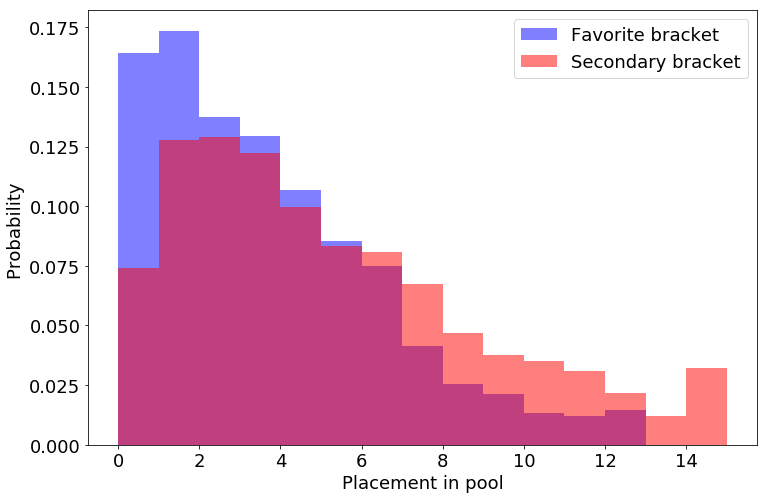

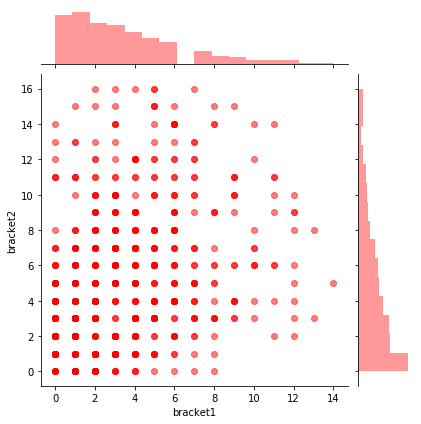

In [208]:
favBracket,newBracket,df,payout,prob,bustPCT=simulatePool(poolSize=15,scaleFactor=0.3);

In [209]:
x={}
x['indx']= []
x['pay1']= []
x['pay2']= []
x['prob1']= []
x['prob2']= []
x['bust']= []
for i in np.arange(5,30,2):
    print(i)
    br1,br2,df,pay,prob,bustPCT=simulatePool(poolSize=i,scaleFactor=0.3,verbose=False);
#     x.append([i,pay[0],pay[1],prob[0],prob[1],bustPCT])
    x['indx'].append(i)
    x['pay1'].append(pay[0])
    x['pay2'].append(pay[1])
    x['prob1'].append(prob[0])
    x['prob2'].append(prob[1])
    x['bust'].append(bustPCT)


5
7
9
11
13
15
17
19
21
23
25
27
29


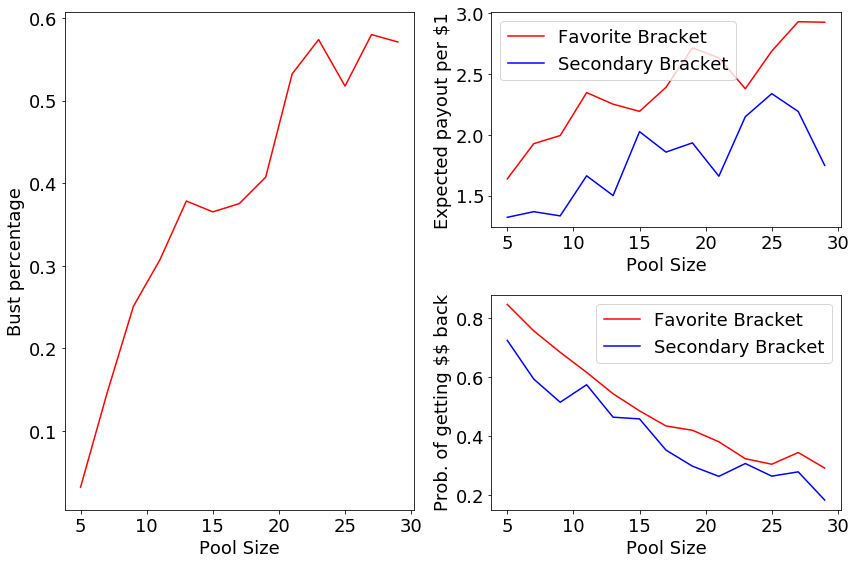

In [220]:
plt.subplot(1,2,1)
plt.plot(x['indx'],x['bust'],'r')
plt.xlabel('Pool Size',size=18)
plt.ylabel('Bust percentage',size=18)
plt.gca().tick_params(labelsize=18)
plt.subplot(2,2,2)
plt.plot(x['indx'],x['pay1'],'r')
plt.plot(x['indx'],x['pay2'],'b')
plt.xlabel('Pool Size',size=18)
plt.ylabel('Expected payout per $1',size=18)
plt.legend(['Favorite Bracket','Secondary Bracket'],fontsize=18)
plt.gca().tick_params(labelsize=18)
plt.subplot(2,2,4)
plt.plot(x['indx'],x['prob1'],'r')
plt.plot(x['indx'],x['prob2'],'b')
plt.xlabel('Pool Size',size=18)
plt.ylabel('Prob. of getting \$\$ back',size=18)
plt.legend(['Favorite Bracket','Secondary Bracket'],fontsize=18)
plt.gca().tick_params(labelsize=18)
plt.tight_layout()

In [117]:
pointsByRound=dict([(i+2, 2**i) for i in np.arange(6)])
# pointsByRound
poolSize=30
placement=[]
for rep in range(100):
    refBracket=np.random.choice(tourneys)
    poolPoints=[]
    for poolBracket in range(poolSize):
        bracket=np.random.choice(tourneys)
        points=compareBrackets(refBracket,bracket,pointsByRound)
        poolPoints.append(points)
    
    favBracket=tourney.simulate()
    points=compareBrackets(refBracket,favBracket,pointsByRound)
    placement.append((np.array(poolPoints)>points).sum())
# plt.hist(poolPoints,bins=np.arange(0,192,5));

0.29292929292929293

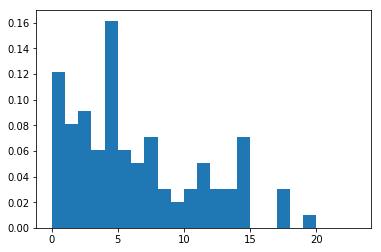

In [118]:
vals,bins,patch=plt.hist(placement,bins=range(max(placement)),normed=True);
vals[:3].sum()

(0, 192)

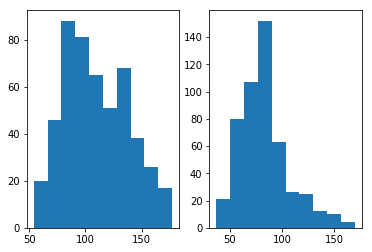

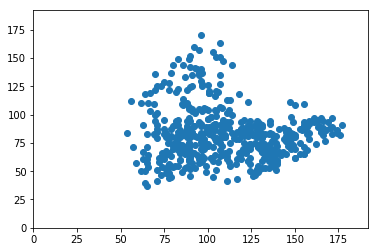

In [245]:
pointsByRound=dict([(i+2, 2**i) for i in np.arange(6)])
# pointsByRound
pointList1=[]
pointList2=[]
favBracket=tourney.simulate()
newBracket2=tourney.simulate(simLevel='random')
for rep in range(500):
    refBracket=tourney.simulate(simLevel='random')
    points=compareBrackets(refBracket,favBracket,pointsByRound)
    pointList1.append(points)

    points=compareBrackets(refBracket,newBracket2,pointsByRound)
    pointList2.append(points)

plt.subplot(1,2,1)
plt.hist(pointList1);
plt.subplot(1,2,2)
plt.hist(pointList2);
plt.figure()
plt.scatter(pointList1,pointList2)
plt.xlim(0,32*6)
plt.ylim(0,32*6)

# Simulate tournament

In [177]:
tourn=initializeTourney(year=2017)
%timeit bracket=tourn.simulate(simLevel='random');

2.43 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [179]:
%lprun -f initializeTourney initializeTourney()

In [131]:
df=pd.DataFrame(columns=features)
df

teamAName='toledo'
teamBName='north-carolina'


teamA=teamData[teamData.name==teamAName]
teamB=teamData[teamData.name==teamBName]
teamA.index=[0]
teamB.index=[0]

df[features]=teamA[features]-teamB[features]

df

,3PAr,AST,AdjD,AdjEM,AdjEM.1,AdjO,AdjT,BLK,FT/FGA,FTr,Luck,NCSOS_AdjEM,OppD,OppO,TOV,TRB,TS,eFG
0,0.009,-5.0,10.4,-18.45,-11.8,-8.0,-3.5,1.6,0.096,0.096,-0.026,-0.6,5.7,-6.1,1.5,-4.1,0.006,-0.016


In [132]:
clf.predict_proba(df)

array([[ 0.96230603,  0.03769397]])

In [134]:
teamA

,3PAr,AST,AdjD,AdjEM,AdjEM.1,AdjO,AdjT,BLK,FT/FGA,FTr,Luck,NCSOS_AdjEM,OppD,OppO,TOV,TRB,TS,eFG,name,fullName
0,0.321,55.2,105.5,-1.31,-3.23,104.2,66.1,9.7,0.286,0.286,0.012,-1.55,103.7,100.5,15.6,44.5,0.531,0.483,toledo,Toledo
